# Yang et al. 2024

[Yang, W., Bai, X., Guan, X., Zhou, C., Guo, T., Wu, J., ... & Tian, J. (2024). The longitudinal volumetric and shape changes of subcortical nuclei in Parkinson’s disease. Scientific Reports, 14(1), 7494.](https://www.nature.com/articles/s41598-024-58187-4)

## Demographics

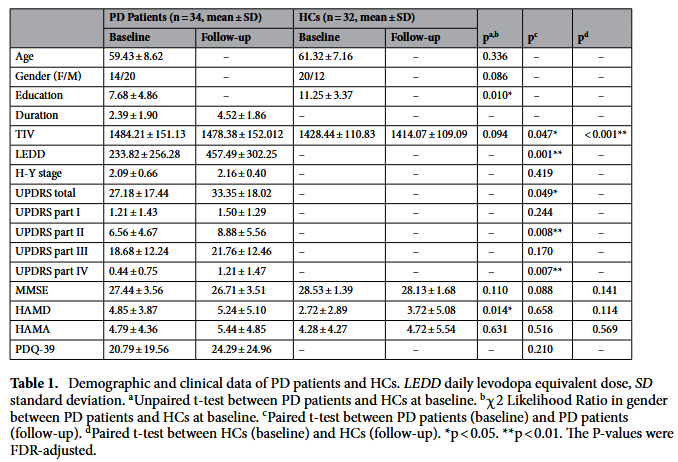

## Results

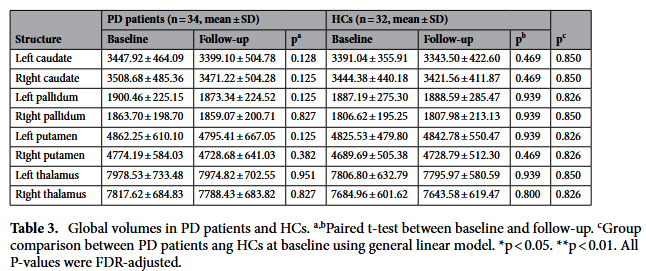

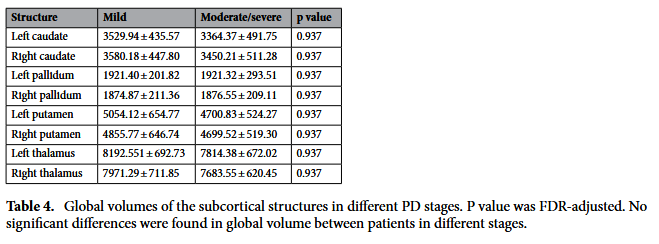

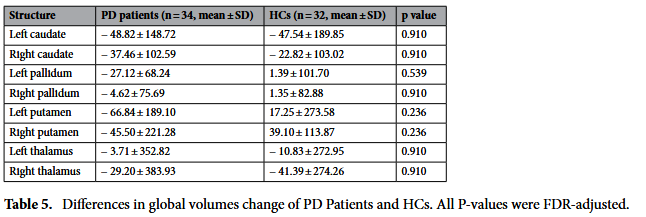

## Consistency analysis

In [2]:
import pandas as pd
from pathlib import Path

anonymizer = True

root_dir = Path.cwd().parent.parent.parent.parent.resolve()

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Yang_2024"
assert data_dir.exists(), f"Data dir does not exist: {anondir(data_dir)}"
print(f"Using data dir: {anondir(data_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Yang_2024


### Load NPV maps

In [3]:
npv_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume.csv"
)
npv_hc_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc_baseline-hc_followup_subcortical_volume.csv"
)
npv_pd_subcortical_volume = pd.read_csv(
    npv_dir / "npv_pd_baseline-pd_followup_subcortical_volume.csv"
)
npv_subcortical_volume_bil = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume_bilateral.csv"
)
npv_subcortical_volume_long = pd.read_csv(
    npv_dir / "npv_hc-pd_subcortical_volume_longitudinal.csv"
)

### Formula

In [4]:
import numpy as np
import scipy.stats


# T-test
def two_sample_t_value(m1, m2, s1, s2, n1, n2):
    return (m1 - m2) / np.sqrt(s1**2 / n1 + s2**2 / n2)


def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n - 2) / (n - 1)) * npv

In [5]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, group):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
        "group",
    ]
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value", color="group")
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        color="group",
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=f"Group differences ({group})",
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

## Results

### Table 3 - Group comparison

In [7]:
df = pd.read_csv(data_dir / "table_3.csv")

n_hc = 34
n_pd = 32

df_pd = df[
    [
        "region",
        "PD_Baseline_mean",
        "PD_Followup_mean",
        "PD_Baseline_sd",
        "PD_Followup_sd",
        "PD_p",
    ]
]
df_pd = pd.merge(df_pd, npv_pd_subcortical_volume, on="region")
df_pd["t"] = two_sample_t_value(
    df_pd["PD_Baseline_mean"],
    df_pd["PD_Followup_mean"],
    df_pd["PD_Baseline_sd"],
    df_pd["PD_Followup_sd"],
    n_pd,
    n_pd,
)
df_pd["std_p"] = std_p_t(df_pd["t"], n_pd + n_pd - 2, df_pd["npv"])
df_pd["std_p_low"] = std_p_t(df_pd["t"], n_pd + n_pd - 2, df_pd["npv_CI_low"])
df_pd["std_p_high"] = std_p_t(df_pd["t"], n_pd + n_pd - 2, df_pd["npv_CI_high"])
df_pd["proba_significant"] = flip_proba_beta(df_pd["PD_p"], df_pd["std_p"])
df_pd["sample_size"] = 2 * n_pd
df_pd["group"] = "PD"
df_pd.columns = df_pd.columns.str.replace("PD_", "")

df_hc = df[
    [
        "region",
        "HC_Baseline_mean",
        "HC_Followup_mean",
        "HC_Baseline_sd",
        "HC_Followup_sd",
        "HC_p",
    ]
]
df_hc = pd.merge(df_hc, npv_hc_subcortical_volume, on="region")
df_hc["t"] = two_sample_t_value(
    df_hc["HC_Baseline_mean"],
    df_hc["HC_Followup_mean"],
    df_hc["HC_Baseline_sd"],
    df_hc["HC_Followup_sd"],
    n_hc,
    n_hc,
)
df_hc["std_p"] = std_p_t(df_hc["t"], n_hc + n_hc - 2, df_hc["npv"])
df_hc["std_p_low"] = std_p_t(df_hc["t"], n_hc + n_hc - 2, df_hc["npv_CI_low"])
df_hc["std_p_high"] = std_p_t(df_hc["t"], n_hc + n_hc - 2, df_hc["npv_CI_high"])
df_hc["proba_significant"] = flip_proba_beta(df_hc["HC_p"], df_hc["std_p"])
df_hc["sample_size"] = 2 * n_hc
df_hc["group"] = "HC"
df_hc.columns = df_hc.columns.str.replace("HC_", "")

df_sv = pd.concat([df_pd, df_hc])
df_sv.rename(columns={"p": "p_value"}, inplace=True)
df_sv["analysis"] = "Table 3"

df_sv["alpha"] = 0.05
df_sv["significant"] = df_sv["p_value"] < df_sv["alpha"]
df_sv["test"] = "T"
df_sv["metric"] = "subcortical volume"
df_sv["study"] = "longitudinal"
df_t3 = df_sv.copy()

In [8]:
plot_dumbbell(df_t3, "Subcortical volume")

### Table 4

In [9]:
df = pd.read_csv(data_dir / "table_4.csv")

n_pd_m = 17
n_pd_s = 17

df_pd = df[
    ["region", "Mild_mean", "Mild_sd", "ModerateSevere_mean", "ModerateSevere_sd", "p"]
]
df_pd = pd.merge(df_pd, npv_pd_subcortical_volume, on="region")
df_pd["t"] = two_sample_t_value(
    df_pd["Mild_mean"],
    df_pd["ModerateSevere_mean"],
    df_pd["Mild_sd"],
    df_pd["ModerateSevere_sd"],
    n_pd_m,
    n_pd_s,
)
df_pd["sample_size"] = n_pd_m + n_pd_s
df_pd["std_p"] = std_p_t(df_pd["t"], n_pd_m + n_pd_s - 2, df_pd["npv"])
df_pd["std_p_low"] = std_p_t(df_pd["t"], n_pd_m + n_pd_s - 2, df_pd["npv_CI_low"])
df_pd["std_p_high"] = std_p_t(df_pd["t"], n_pd_m + n_pd_s - 2, df_pd["npv_CI_high"])
df_pd["proba_significant"] = flip_proba_beta(df_pd["p"], df_pd["std_p"])
df_pd["group"] = "PD"
df_pd.rename(columns={"p": "p_value"}, inplace=True)
df_pd["analysis"] = "Table 4"
df_pd["alpha"]  = 0.05
df_pd["significant"] = df_pd["p_value"] < df_pd["alpha"]
df_pd["test"] = "T"
df_pd["metric"] = "subcortical volume"
df_pd["study"] = "cross-sectional"
df_t4 = df_pd.copy()

In [10]:
plot_dumbbell(df_t4, "PD Mild vs ModerateSevere")

### Table 5

In [11]:
df = pd.read_csv(data_dir / "table_5.csv")

n_pd = 34
n_hc = 32

df = df[["region", "PD_mean", "PD_sd", "HC_mean", "HC_sd", "p"]]
df = pd.merge(df, npv_subcortical_volume_long, on="region")
df["t"] = two_sample_t_value(
    df["PD_mean"],
    df["HC_mean"],
    df["PD_sd"],
    df["HC_sd"],
    n_pd,
    n_hc,
)
df["sample_size"] = n_pd + n_hc
df["std_p"] = std_p_t(df["t"], n_pd + n_hc - 2, df["npv"])
df["std_p_low"] = std_p_t(df["t"], n_pd + n_hc - 2, df["npv_CI_low"])
df["std_p_high"] = std_p_t(df["t"], n_pd + n_hc - 2, df["npv_CI_high"])
df["proba_significant"] = flip_proba_beta(df["p"], df["std_p"])
df["group"] = "PD-vs-HC"
df.rename(columns={"p": "p_value"}, inplace=True)
df["analysis"] = "Table 5"
df["alpha"]  = 0.05
df["significant"] = df["p_value"] < df["alpha"]
df["test"] = "T"
df["metric"] = "subcortical volume"
df["study"] = "longitudinal"
df_t5 = df.copy()

In [12]:
plot_dumbbell(df_t5, "PD vs HC")

In [13]:
df = pd.concat([df_t3, df_t4, df_t5], ignore_index=True)
# Assert dataframe contains "proba_significant" and "significant" columns
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)